In [ ]:
'''
Two steps
1. take the max of sensitivity map as the detection limit. [cts/s/pixel]
2. check with the sb histogram of the point sources. 
Decide which sources are excluded and which are not. 
'''

In [311]:
from astropy.io import fits
import numpy as np
from glob import glob
import os
import matplotlib.pyplot as plt
import pandas as pd


In [ ]:
# define plot function
from astropy.wcs import WCS
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve

kernel = Gaussian2DKernel(x_stddev=4)

def imshow_fig(image_data, title):
    fig = plt.figure(figsize = (6,6))
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=WCS(f'{file}'))
    ra = ax.coords[0]
    dec = ax.coords[1]

    ra.set_axislabel('RA')
    dec.set_axislabel('Dec')
    image_data = np.where(np.isfinite(np.log10(image_data)), image_data, np.nan)
    astropy_conv = convolve(image_data, kernel)
    ax.set_title(title)
    # print(np.nanmax(np.log10(image_data)), np.nanmin(np.log10(image_data)[image_data>0]))
    im = ax.matshow(np.log10(astropy_conv), vmin = -0.1,vmax = 0.2, cmap='gnuplot2', origin='lower')
    cbar = fig.colorbar(im)

STEP1 check the sensitivity map and see if reduce the sensitivity map will there be point sources visible or not



In [312]:
#*-fovimten.fits means the sensitivity map of 0.7-7 keV [cts/s/pixel]
datapath = '/Users/eusracenorth/Documents/work/XGAP-ABUN/data/origin/sron/cheese_rate000001_ml01_350-7000_dist1'

# for name in ['mos1S001', 'mos2S002', 'pnS003']:
#     sen = fits.open(f'{datapath}/{name}-fovimtsen.fits')[0].data
#     dat = fits.open(f'{datapath}/{name}-fovimt.fits')[0].data
#     print(name, (sen.max())/17.52/1e3, np.min(sen[sen>0])/17.52/1e3, 'cts/pix')
#     imshow_fig(dat-sen.max(), name)



STEP2 get the fluxes of all the point sources
Steps:
0) create a new and complete sources.fits from emllist.fits
1) use 'region' to generate bkg and source regions
2) use mos/pnspectra to extract spectrums from bkg or source regions.
3) convert values in spectrums to cts/s/arcsec2
4) make the hist

Take the batch method in region command in sas? 
Take the ellipse region around the source exclude the source with circle as the bkg region


0 create emllist_complete.fits

In [244]:
'''
# eye inspect and add source to emllist.fits -> emllist_compelete.fits

# adding criteria:
### 1. not exclude the center of the group
### 2. add the missing source (which criteria?)

Note: emllist_complete.fits only has reasonable ra dec, x_ima, y_ima, the rest values are wrong. 
'''

# group center
center = ()
center_err = ()

# point sources centers
ps_centers = [()]
ps_centers_err = [()]

filename = f'{datapath}/emllist.fits'
os.system(f'cp {filename} {filename.split(".")[0]}_complete.fits')

f = fits.open(filename)
dat = f[1].data
f.close()
dat['FLAG'] = 0

# load the styles of the recarray data 
sample_dype = dat.dtype
sample = dat[0]

# load the regions of complete pointsources
srcname = f'{datapath}/../sources.reg'
regfile = open(srcname)
lines = regfile.readlines()
regfile.close()

regfile = open(f'{datapath}/../sources_ima.reg')
ima_lines = regfile.readlines()
regfile.close()
ima_lines = ima_lines[3:]

num = len(lines)-3
dat = dat[:num]

for i, f in enumerate(lines[3:]):
    ra = f.split('(')[-1].split(',')[0]
    dec = f.split(',')[1]
    dat[i]['RA'] = ra
    dat[i]['DEC'] = dec
    dat[i]['ML_ID_SRC'] = int(i+1)
    dat[i]['DIST_NN'] = 1000
    dat[i]['DET_ML'] = 20
    dat[i]['BOX_ID_SRC'] = int(i+1)
    dat[i]['ID_INST'] = 0
    dat[i]['ID_BAND'] = 0
    dat[i]['ID_CLUSTER'] = int(i+1)

    # # needed for region command to generate bkgregtdet file
    ## doesn't work for region even I change the x_ima, y_ima
    ## alter the *bkgregtdet.fits directly
    # x_ima = ima_lines[i].split('(')[-1].split(',')[0]
    # y_ima = ima_lines[i].split(',')[1]
    # dat[i]['X_IMA'] = x_ima
    # dat[i]['Y_IMA'] = y_ima
    # dat[i]['X_IMA_ERR'] = 0.1
    # dat[i]['Y_IMA_ERR'] = 0.1

print(dat['RA'], dat['DEC'])

newf = fits.open(f'{filename.split(".")[0]}_complete.fits', mode='update')
newf['SRCLIST'].data = dat
newf.flush()
newf.close()



[170.5524771 170.9384357 170.5829122 170.6631515 170.9057223 170.9476408
 170.6935442 170.6434728 170.8276008 170.5771871 170.5814189 170.60554
 170.6340919 170.5082619 170.8942867 170.9072954 170.6442409 170.9196816
 170.6194411 170.7885266 170.7205838 170.7870379 170.6354747 170.6354992
 170.8961338] [34.0429534 34.2057123 34.1578746 33.9690245 34.170841  34.1480532
 34.0367061 34.1080043 34.1269789 34.0683157 34.2034716 34.2597458
 34.2528864 34.1277722 33.9723895 34.1298428 34.0991623 34.1351332
 34.1809896 34.0973362 34.3418878 34.2411853 33.9861565 33.9652333
 34.0890425]


00 Create *bkgregtdet.fits file

In [310]:
# for *bkgregt*.fits
datapath = '/Users/eusracenorth/Documents/work/XGAP-ABUN/data/origin/sron/cheese_rate000001_ml01_350-7000_dist1'
os.chdir(datapath)


# Define the data type for the NumPy array
# dtype = [('SHAPE', 'U16'), ('X', np.float64, (4,)), ('Y', np.float64, (4,)), ('R', np.float64, (4,)), ('ROTANG', np.float64, (4,)), ('COMPONENT', int)]

for name in ['mos1S001', 'mos2S002', 'pnS003']:

    os.system(f'cp ori1-bkgregtdet.fits {name}-bkgregtdet.fits')
    datf = open(f'sources_det.reg')
    lines = datf.readlines()[3:]
    datf.close()
    orif = fits.open(f'{name}-bkgregtdet.fits', mode='update')

    dat = orif[1].data


    ## initialize
    # for col in ['SHAPE', 'DETX', 'DETY', 'R', 'ROTANG', 'COMPONENT']:
    #     dat[col] = [[]]* len(lines)
    
    for i in range(len(lines)):
        # print(i)
        line = lines[i]
        print(line)
        ## SHAPE, X, Y, R, ROTANG, COMPONENT
        dat[i][0] = f"!{line.split('(')[0][1:].upper()}"
        dat[i][1] = [float(line.split('(')[-1].split(',')[0]), 0,0,0]
        dat[i][2] = [float(line.split(',')[1]),0,0,0]
        dat[i][3] = [float(line.split(',')[2][:-1]), float(line.split(',')[3][:-1]),0,0]
        dat[i][4] = [float(line.split(',')[-1].split(')')[0]),0,0,0]
        dat[i][5] = 1
    orif[1].data = dat
    print(dat)
    orif.flush()


ellipse(36735.855,23079.223,410.21352,299.85987,71.320496)

ellipse(13732.777,34800.539,481.8393,283.29577,56.841713)

ellipse(34907.867,31350.617,394.95479,307.81897,298.60429)

ellipse(30136.619,17748.205,396.26537,312.15341,23.67374)

ellipse(15676.515,32286.191,354.59144,239.05518,61.827099)

ellipse(13175.963,30650.186,386.10294,237.75739,72.885559)

ellipse(28319.875,22620.309,277.12866,260.19604,27.390013)

ellipse(31302.852,27755.688,263.07638,241.23912,282.58624)

ellipse(20327.363,29122.051,347.00157,311.55618,67.129524)

ellipse(35258.84,24902.877,374.64395,300.12894,79.17704)

ellipse(34991.945,34633.746,200,200,0)

ellipse(33550.508,38683.543,452.49098,277.6515,328.7859)

ellipse(31851.924,38187.758,366.90332,235.98614,334.12543)

ellipse(39360.305,29191.436,372.96206,233.1169,281.06608)

ellipse(16335.307,17996.539,200,200,0)

ellipse(15577.794,29334.471,344.11477,244.83194,75.753586)

ellipse(31257.619,27119.023,264.18679,243.48314,275.61386)

ellipse(14840.273,29716.68,

In [281]:
# Assuming column data types
column_data_types = [('SHAPE', '16A'), ('X', '4E', (4,)), ('Y', '4E', (4,)), ('R', '4E', (4,)), ('ROTANG', '4E', (4,)), ('COMPONENT', 'J')]

# Initialize an empty list to store region data
arr = []

# Convert FITS_rec data to a list of tuples
fits_data = list(orif[1].data)

for i, line in enumerate(lines):
    # Parse region data from the line
    parts = line.split(',')
    shape = f"!{parts[0].split('(')[0].upper()}"
    x = [float(parts[0].split('(')[1]), 0.0, 0.0, 0.0]  # 4 values for 'X'
    y = [float(parts[1]), 0.0, 0.0, 0.0]  # 4 values for 'Y'
    r = [float(parts[2][:-1]), float(parts[3][:-1]), 0.0, 0.0]  # 4 values for 'R'
    rotang = [float(parts[4].split(')')[0]), 0.0, 0.0, 0.0]  # 4 values for 'ROTANG'
    component = 1

    # Update the corresponding row in the FITS data
    fits_data[i] = (shape, x, y, r, rotang, component)

# Update the FITS data with the new region data
orif[1].data = fits_data

# Update the data types
for name, data_type, shape in column_data_types:
    orif[1].data[name].dtype = (data_type, shape)

orif.flush()


TypeError: Table data has incorrect type.

In [ ]:
# 1) use 'region' to generate bkg and source regions
## ## mos2S002-allevc-nechip5.fits
region eventset=mos2S002-allevc-nechip5.fits srclisttab=emllist_complete.fits:SRCLIST operationstyle=batch energyfraction=0.5 radiusstyle=contour srcidcol=ML_ID_SRC shrinkconfused=no nosrcellipse=no nobkgellipse=no fovbkgannulus=no outunit=xy verbosity=10 regionset=sources_mos2S002_sky_srcreg.fits bkgregionset=sources_mos2S002_sky_bkgreg.fits | tee mos2S002-region.log

#bkgratestyle=user/ col
# bkgfraction=3
## fovbkgannulus=no # means the bkg will be around source\ 
## outunit=detxy # for detxy #outunit=xy # for sky \

In [ ]:
region eventset=mos1S001-allevc.fits srclisttab=emllist_complete.fits:SRCLIST operationstyle=batch energyfraction=0.5 radiusstyle=contour srcidcol=ML_ID_SRC shrinkconfused=no nosrcellipse=no nobkgellipse=no fovbkgannulus=no outunit=xy verbosity=10 regionset=sources_mos1S001_sky_srcreg.fits bkgregionset=sources_mos1S001_sky_bkgreg.fits | tee mos1S001-region.log



1 save the regions in one file

In [ ]:
# convert the output file to the ds9 region file
#physical; circle 6500 9320 3'
for name in ['mos1S001', 'mos2S002', 'pnS003']:
    src_f = fits.open(f'{datapath}/sources_{name}_sky_srcreg.fits')
    CDELT = 6.94E-04 * 60 # arcmin per pixel
    num = len(src_f)-1

    new_src_f = open(f'{datapath}/sources_{name}_xy_srcreg.reg', 'w')
    new_src_f.write('physical\n')

    for i in range(1, len(src_f)):
        dat = src_f[i].data
        x = dat['X'][0][0]
        y = dat['Y'][0][0]
        r = dat['R'][0][0]
        if r > 0:
            r1 = dat['R'][0][0] * CDELT
            r2 = dat['R'][0][1] * CDELT
            rot = dat['ROTANG'][0][0]
            
        else:
            r1 = 10
            r2 = 10
            rot = 0
        new_src_f.write(f'ellipse({x}, {y}, {r1}", {r2}", {rot})\n')

    new_src_f.close()



In [ ]:
# convert the output file to the ds9 region file
#physical; circle 6500 9320 3'
for name in ['mos1S001', 'mos2S002', 'pnS003']:

    src_f = fits.open(f'{datapath}/sources_{name}_sky_bkgreg.fits')
    CDELT = 6.94E-04 * 60 # arcmin per pixel
    num = len(src_f)-1

    new_src_f = open(f'{datapath}/sources_{name}_xy_bkgreg.reg', 'w')
    new_src_f.write('physical\n')

    for i in range(1, len(src_f)):
        dat = src_f[i].data        
        x = dat['X'][0][0]
        y = dat['Y'][0][0]
        r = dat['R'][0][0]
        if r > 0:
            r1 = dat['R'][0][0] * CDELT
            r2 = dat['R'][0][1] * CDELT
            rot = dat['ROTANG'][0][0]
            
        else:
            r1 = 10
            r2 = 30
            rot = 0
        new_src_f.write(f'annulus({x}, {y}, {r1}", {r2}", n=1)\n')
        for j in range(1, len(dat)):
            x = dat['X'][j][0]
            y = dat['Y'][j][0]
            r = dat['R'][j][0]
            if r > 0:
                r1 = dat['R'][j][0] * CDELT
                r2 = dat['R'][j][1] * CDELT
                rot = dat['ROTANG'][j][0]
                
            else:
                r1 = 10
                r2 = 10
                rot = 0
            new_src_f.write(f'-ellipse({x}, {y}, {r1}", {r2}", {rot})\n')
            

    new_src_f.close()



2 save the regions separately

In [ ]:
# convert the output file to the ds9 region file
#physical; circle 6500 9320 3'
for name in ['mos1S001', 'mos2S002', 'pnS003']:

    src_f = fits.open(f'{datapath}/sources_{name}_sky_srcreg.fits')
    CDELT = 6.94E-04 * 60 # arcsec per pixel

    os.makedirs(f'{datapath}/srcs_regions', exist_ok=True)

    for i in range(1, len(src_f)):
        new_src_f = open(f'{datapath}/srcs_regions/src{i}_xy_{name}.reg', 'w')
        new_src_f.write('physical\n')
        dat = src_f[i].data
        x = dat['X'][0][0]
        y = dat['Y'][0][0]
        r = dat['R'][0][0]
        if r > 0:
            r1 = dat['R'][0][0] * CDELT
            r2 = dat['R'][0][1] * CDELT
            rot = dat['ROTANG'][0][0]
        else:
            r1 = 10
            r2 = 10
            rot = 0
        new_src_f.write(f'ellipse({x}, {y}, {r1}", {r2}", {rot})\n')

        new_src_f.close()



In [ ]:
# convert the output file to the ds9 region file
#physical; circle 6500 9320 3'
for name in ['mos1S001', 'mos2S002', 'pnS003']:

    src_f = fits.open(f'{datapath}/sources_{name}_sky_bkgreg.fits')
    CDELT = 6.94E-04 * 60 # arcsec per pixel

    for i in range(1, len(src_f)):
        new_src_f = open(f'{datapath}/srcs_regions/bkg{i}_xy_{name}.reg', 'w')
        new_src_f.write('physical\n')
        dat = src_f[i].data        
        x = dat['X'][0][0]
        y = dat['Y'][0][0]
        r = dat['R'][0][0]
        if r > 0:
            r1 = dat['R'][0][0] * CDELT
            r2 = dat['R'][0][1] * CDELT
            rot = dat['ROTANG'][0][0]
        else:
            r1 = 10
            r2 = 30
            rot = 0
        new_src_f.write(f'annulus({x}, {y}, {r1}", {r2}", n=1)\n')
        for j in range(1, len(dat)):
            x = dat['X'][j][0]
            y = dat['Y'][j][0]
            r = dat['R'][j][0]
            if r > 0:
                r1 = dat['R'][j][0] * CDELT
                r2 = dat['R'][j][1] * CDELT
                rot = dat['ROTANG'][j][0]
            else:
                r1 = 10
                r2 = 10
                rot = 0
            new_src_f.write(f'-ellipse({x}, {y}, {r1}", {r2}", {rot})\n')
            
        new_src_f.close()



STEP3 extract the spectrum of every source and bkg region

0  adapt the regions to XMM mosspectra expression regions

In [ ]:
# convert the output file to the ds9 region file
#physical; circle 6500 9320 3'
for name in ['mos1S001','mos2S002','pnS003']:

    src_f = fits.open(f'{datapath}/sources_{name}_sky_srcreg.fits')

    os.makedirs(f'{datapath}/srcs_regions',exist_ok=True)

    for i in range(1,len(src_f)):
        new_src_f = open(f'{datapath}/srcs_regions/src{i}_xy_{name}_xmm.reg','w')
        dat = src_f[i].data
        x = dat['X'][0][0]
        y = dat['Y'][0][0]
        r = dat['R'][0][0]
        if r > 0:
            r1 = dat['R'][0][0] 
            r2 = dat['R'][0][1] 
            rot = dat['ROTANG'][0][0]
        else:
            r1 = 10
            r2 = 10
            rot = 0
        new_src_f.write(f'((X,Y) IN ellipse({x:.1f},{y:.1f},{r1:.1f},{r2:.1f},{rot:.1f}))\n')

        new_src_f.close()



In [ ]:
# convert the output file to the ds9 region file
#physical; circle 6500 9320 3'
for name in ['mos1S001','mos2S002','pnS003']:

    src_f = fits.open(f'{datapath}/sources_{name}_sky_bkgreg.fits')

    for i in range(1,len(src_f)):
        new_src_f = open(f'{datapath}/srcs_regions/bkg{i}_xy_{name}_xmm.reg','w')
        dat = src_f[i].data        
        x = dat['X'][0][0]
        y = dat['Y'][0][0]
        r = dat['R'][0][0]
        if r > 0:
            r1 = dat['R'][0][0] 
            r2 = dat['R'][0][1] 
            rot = dat['ROTANG'][0][0]
        else:
            r1 = 10
            r2 = 30
            rot = 0
        new_src_f.write(f'((X,Y) IN annulus({x:.1f},{y:.1f},{r1:.1f},{r2:.1f}))\n')
        for j in range(1,len(dat)):
            x = dat['X'][j][0]
            y = dat['Y'][j][0]
            r = dat['R'][j][0]
            if r > 0:
                r1 = dat['R'][j][0] 
                r2 = dat['R'][j][1] 
                rot = dat['ROTANG'][j][0]
            else:
                r1 = 10
                r2 = 10
                rot = 0
            new_src_f.write(f'&&!((X,Y) IN ellipse({x:.1f},{y:.1f},{r1:.1f},{r2:.1f},{rot:.1f}))\n')
            
        new_src_f.close()



1 extract the spectrums

In [ ]:
# what will regmos1.txt looks like?
mosspectra eventfile=mos1S001-allevc.fits withsrcrem=yes withregion=yes regionfile=regmos1.txt keepinterfiles=yes pattern=12 elow=350 ehigh=1100 ccds="T T T F F F T"

In [ ]:
for name in ['mos1S001-allevc', 'mos2S002-allevc-nechip5', 'pnS003-allevc']:
    regdir = f'{datapath}/srcs_regions'
    os.chdir(regdir)
    regs = glob(f'src*_xy_{name.split("-")[0]}_xmm.reg')

    f = open(f'{regdir}/src_spec_{name}.sh', 'w')
    for reg in regs:

        sf = open(reg)
        lines = sf.readlines()
        lines = [l.strip() for l in lines]
        regtxt = ''.join(lines)
        sf.close()

        if 'mos' in name:
            f.write(f'\n')
            f.write(f'evselect table=../{name}.fits xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 yimagebinsize=80 withimageset=Y imageset={reg.split(".")[0]}_img.fits withspectrumset=Y spectrumset={reg.split(".")[0]}_spec.pi energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=11999 expression="(FLAG==0) && (PATTERN<=12) && {regtxt}"  | tee {reg.split(".")[0]}_spec.log\n')
        else:
            f.write(f'\n')
            f.write(f'evselect table=../{name}.fits xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 yimagebinsize=80 withimageset=Y imageset={reg.split(".")[0]}_img.fits withspectrumset=Y spectrumset={reg.split(".")[0]}_spec.pi energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=20479 expression="(FLAG==0) && (PATTERN<=4) && {regtxt}"  | tee {reg.split(".")[0]}_spec.log\n')
    f.close()


In [ ]:
regdir = f'{datapath}/srcs_regions'
os.chdir(regdir)

for name in ['mos1S001-allevc', 'mos2S002-allevc-nechip5', 'pnS003-allevc']:
    
    regs = glob(f'bkg*_xy_{name.split("-")[0]}_xmm.reg')

    f = open(f'{regdir}/bkg_spec_{name}.sh', 'w')
    for reg in regs:

        sf = open(reg)
        lines = sf.readlines()
        lines = [l.strip() for l in lines]
        regtxt = ''.join(lines)
        sf.close()

        if 'mos' in name:
            f.write(f'\n')
            f.write(f'evselect table=../{name}.fits xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 yimagebinsize=80 withimageset=Y imageset={reg.split(".")[0]}_img.fits withspectrumset=Y spectrumset={reg.split(".")[0]}_spec.pi energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=11999 expression="(FLAG==0) && (PATTERN<=12) && {regtxt}"  | tee {reg.split(".")[0]}_spec.log\n')
        else:
            f.write(f'\n')
            f.write(f'evselect table=../{name}.fits xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 yimagebinsize=80 withimageset=Y imageset={reg.split(".")[0]}_img.fits withspectrumset=Y spectrumset={reg.split(".")[0]}_spec.pi energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=20479 expression="(FLAG==0) && (PATTERN<=4) && {regtxt}"  | tee {reg.split(".")[0]}_spec.log\n')
    f.close()


2 get the sb from the spectrums

/var/folders/sy/vxhnb6x11wz6mkt7x_sw_y140000gn/T/ipykernel_8134/1006494642.py:64: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,20)
/var/folders/sy/vxhnb6x11wz6mkt7x_sw_y140000gn/T/ipykernel_8134/1006494642.py:64: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,20)


[ 1.34999960e+01  4.49353946e-12 -2.35282321e+00  4.00000000e-06]
x_break_flux_to_mos = 4e-06
[13.49999597 13.49999597 10.40644478  4.7151358   2.61035446  1.62799245
  1.09889141  0.78475246  0.58457392]
[ 1.80000865e+01  8.36585436e-05 -9.68404788e-01  3.00000000e-06]
x_break_flux_to_mos = 3.0000000000000005e-06
[18.00008651 16.84884883 10.27391313  7.41697752  5.8147646   4.7878028
  4.07266202  3.54563829  3.14090286]


/var/folders/sy/vxhnb6x11wz6mkt7x_sw_y140000gn/T/ipykernel_8134/1006494642.py:64: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,20)


[ 1.33333234e+01  1.23587590e-07 -1.56866519e+00  7.00000000e-06]
x_break_flux_to_mos = 2.534981549815498e-06
[13.33332343 13.33332343 13.33332343 12.77928526  8.61583517  6.28910975
  4.83929755  3.86628351  3.17705845]


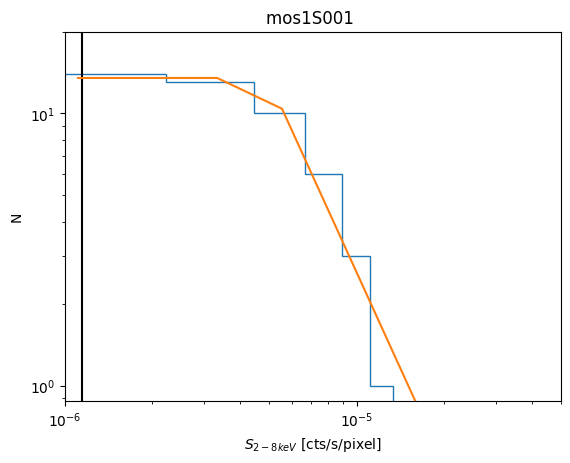

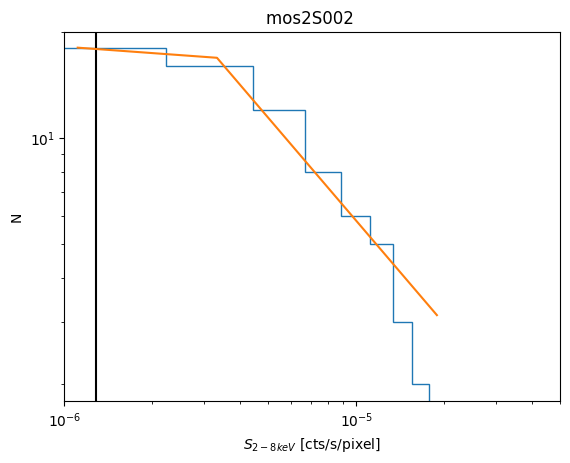

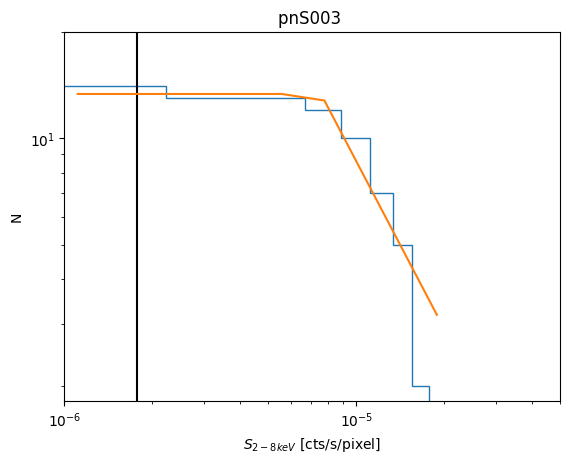

In [388]:
from scipy.optimize import curve_fit

flux2cts = [4.907, 4.907, 13.55] # thin

sens = [1.15e-6, 1.28e-6, 1.78e-6]
xbreak_init = [4e-6, 3e-6, 7e-6]
regdir = f'{datapath}/srcs_regions'
os.chdir(regdir)

def broken_power_law(x, a1, a2, b2, x_break):
    b1=0
    y = np.piecewise(x, [x < x_break, x >= x_break], [lambda x: a1 * x ** b1, lambda x: a2 * x ** b2])
    return y


for j, name in enumerate(['mos1S001', 'mos2S002', 'pnS003']):
    # read the s* arcmin2
    df = pd.read_csv(f'wcs_src_areas_{name}.csv')
    srcarea = df['srcarea[s arcmin2]']
    bkgarea = df['bkgarea[s arcmin2]']

    # tranverse the channels to energies
    rmf_file = glob(f'*_{name}_xmm_spec.rmf')
    f = fits.open(rmf_file[0])
    ch2en = f[2].data
    f.close()

    elo = ch2en['E_MIN']
    # ehi = ch2en['E_MAX']
    # ch = ch2en['CHANNEL']
    emsk = (elo < 8.0) & (elo >2.0)
    cts = np.zeros(25)

    for i in range(1, 26):
        srcspec = f'src{i}_xy_{name}_xmm_spec.pi'
        f = fits.open(f'{srcspec}')
        spec = f[1].data
        cts[int(i-1)] = np.sum(spec['COUNTS'][emsk])
    
    srcctr = cts/srcarea*CDELT**2

    for i in range(1, 26):
        srcspec = f'bkg{i}_xy_{name}_xmm_spec.pi'
        f = fits.open(f'{srcspec}')
        spec = f[1].data
        cts[int(i-1)] = np.sum(spec['COUNTS'][emsk])
    
    bkgctr = cts/bkgarea*CDELT**2
    fig = plt.subplots()
    plt.title(f'{name} ')
    plt.xlabel(f'$S_{{2-8keV}}$ [cts/s/pixel]')
    plt.ylabel('N')

    plt.axvline(sens[j], c = 'k')
    

    y, x = np.histogram(srcctr-bkgctr, bins = np.linspace(1e-10, 2e-5, 10))

    hist_y = np.cumsum(y[::-1])[::-1]
    plt.stairs(hist_y, x)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim(1e-6, 5e-5)
    plt.ylim(0,20)


    initial_guess = [1, 1, -0.1, xbreak_init[j]]  # a1, b1, a2, b2, x_break
    parameter_bounds = ([0, 0, -np.inf, 0], [np.inf, np.inf, 0, 5e-5])

    x_mid = x[0:-1] + np.diff(x)/2
    params, covariance = curve_fit(broken_power_law, x_mid[:-1], hist_y[:-1], p0=initial_guess, bounds=parameter_bounds)
    a1, a2, b2, x_break = params

    print(params)
    print(f'x_break_flux_to_mos = {x_break/flux2cts[j] * flux2cts[0]}')
    y_fit = broken_power_law(x_mid, a1, a2, b2, x_break)
    print(y_fit)
    plt.plot(x_mid, y_fit)
    # plt.hist(srcctr-bkgctr, bins = np.linspace(1e-7, 2e-5, 20))
    # plt.xlim(1e-7, 2e-5)


3 determine the area of the point sources regions

In [ ]:
# f = open(f'{datapath}/cal_regionarea.sh', 'w')

CDELT = 6.94E-04 * 60 # arcsec per pixel
os.system('heainit')

for name in ['mos1S001', 'mos2S002', 'pnS003']:
    dir = {}
    dir['srcidx'] = np.arange(1,26)
    dir['srcarea[arcsec2]'] = np.zeros(25)
    dir['bkgarea[arcsec2]'] = np.zeros(25)

    for i in range(1,26):
        
        srcreg = f'wcs_src{int(i)}.reg'
        bkgreg = f'wcs_bkg{int(i)}.reg'

        os.system(f'ftimgcalc {srcreg.split(".")[0]}_{name}_msk.fits \'regfilter("{srcreg}",A.P1,A.P2) ? (1):(0)\' a={name}-fovimt.fits clobber=yes')
        os.system(f'ftimgcalc {bkgreg.split(".")[0]}_{name}_msk.fits \'regfilter("{bkgreg}",A.P1,A.P2) ? (1):(0)\' a={name}-fovimt.fits clobber=yes')
        
        os.system(f'fimgstat {srcreg.split(".")[0]}_{name}_msk.fits threshlo=I threshup=I > {srcreg.split(".")[0]}_{name}_msk.log')
        os.system(f'fimgstat {bkgreg.split(".")[0]}_{name}_msk.fits threshlo=I threshup=I > {bkgreg.split(".")[0]}_{name}_msk.log')
        
        f = open(f'{srcreg.split(".")[0]}_{name}_msk.log')
        lines = f.readlines()
        f.close()
        for line in lines:
            if 'sum' in line:
                dir['srcarea[arcsec2]'][int(i-1)] = float(line.split('=')[-1])

        f = open(f'{bkgreg.split(".")[0]}_{name}_msk.log')
        lines = f.readlines()
        f.close()
        for line in lines:
            if 'sum' in line:
                dir['bkgarea[arcsec2]'][int(i-1)] = float(line.split('=')[-1])

    df = pd.DataFrame(dir)
    df.to_csv(f'wcs_src_areas_{name}.csv', index=False)
        # backexp="{bkgtxt}"
            


In [209]:
# farith with *-fovimtmask.fits to calculate the pixel number of every region

# f = open(f'{datapath}/cal_regionarea.sh', 'w')

CDELT = 6.94E-04  # arcmin per pixel

f = open('cal_reg.sh', 'w')

for name in ['mos1S001', 'mos2S002', 'pnS003']:
    dir = {}
    dir['srcidx'] = np.arange(1,26)
    dir['srcarea[s arcmin2]'] = np.zeros(25)
    dir['bkgarea[s arcmin2]'] = np.zeros(25)

    for i in range(1,26):
        
        srcreg = f'wcs_src{int(i)}.reg'
        bkgreg = f'wcs_bkg{int(i)}.reg'

#         f.write(f'ftimgcalc {srcreg.split(".")[0]}_{name}_msk.fits \'regfilter("{srcreg}",A.P1,A.P2) ? (1):(0)\' a={name}-fovimt.fits clobber=yes \n')
#         f.write(f'ftimgcalc {bkgreg.split(".")[0]}_{name}_msk.fits \'regfilter("{bkgreg}",A.P1,A.P2) ? (1):(0)\' a={name}-fovimt.fits clobber=yes \n')
        
#         f.write(f'farith {srcreg.split(".")[0]}_{name}_msk.fits {name}-fovimtexp.fits {srcreg.split(".")[0]}_{name}_msk_exp.fits "*"\n')
#         f.write(f'farith {bkgreg.split(".")[0]}_{name}_msk.fits {name}-fovimtexp.fits {bkgreg.split(".")[0]}_{name}_msk_exp.fits "*"\n')

#         f.write(f'fimgstat {srcreg.split(".")[0]}_{name}_msk_exp.fits threshlo=I threshup=I > {srcreg.split(".")[0]}_{name}_msk.log\n')
#         f.write(f'fimgstat {bkgreg.split(".")[0]}_{name}_msk_exp.fits threshlo=I threshup=I > {bkgreg.split(".")[0]}_{name}_msk.log\n')
        
        
# f.close()
        f = open(f'{srcreg.split(".")[0]}_{name}_msk.log')
        lines = f.readlines()
        f.close()
        for line in lines:
            if 'sum' in line:
                dir['srcarea[s arcmin2]'][int(i-1)] = float(line.split('=')[-1]) * CDELT**2

        f = open(f'{bkgreg.split(".")[0]}_{name}_msk.log')
        lines = f.readlines()
        f.close()
        for line in lines:
            if 'sum' in line:
                dir['bkgarea[s arcmin2]'][int(i-1)] = float(line.split('=')[-1]) * CDELT**2

    df = pd.DataFrame(dir)
    df.to_csv(f'wcs_src_areas_{name}.csv', index=False)
        # backexp="{bkgtxt}"
            


SUP gen arf and rmf

In [ ]:
f = open(f'gen_rmf.sh', 'w')

specfiles = glob('*.pi')

for specfile in specfiles:
    
    if 'mos1' in specfile:
        badpix_file = f'mos1S001-fovimt.fits'
    elif 'mos2' in specfile:
        badpix_file = f'mos2S002-fovimt.fits'
    else:
        badpix_file = f'pnS003-fovimt.fits'

    f.write(f'''
rmfgen spectrumset={specfile} rmfset={specfile.split('.')[0]}.rmf detmaptype=flat extendedsource=yes badpixlocation={badpix_file}\n
        ''') 

f.close()


# arfgen spectrumset=source_{inst}_{obs}_bkg_spec_bin5.fits {set3} rmfset=source_{inst}_{obs}_bkg.rmf arfset=source_{inst}_{obs}_bkg.arf badpixlocation={inst}_hiband_loband_clean_fov.fits\n
#     for reg in ['oofov']:#['reg1', 'reg2', 'reg3', 'reg4', 'reg5']:
#         f.write(f'''
# rmfgen spectrumset=source_{inst}_{obs}_{reg}_spec_bin.fits rmfset=source_{inst}_{obs}_{reg}.rmf detmaptype=flat extendedsource=yes badpixlocation={inst}_hiband_loband_clean_fov.fits\n
#         ''')# arfgen spectrumset=source_{inst}_{obs}_{reg}_spec.fits {set3} rmfset=source_{inst}_{obs}_{reg}.rmf arfset=source_{inst}_{obs}_{reg}.arf badpixlocation={inst}_hiband_loband_clean_fov.fits\n

# f = open(f'gen_arf_rmf_{obs}.sh')
# print(f.readlines())

In [ ]:
def lines2oneline(lines):
    lines = [line.strip() for line in lines]
    regtxt = ''.join(lines)
    return regtxt

In [ ]:
file = open(f'../wcs_srcreg.reg')
lines = file.readlines()
file.close()

for i, line in enumerate(lines[3:]):
    newf = open(f'wcs_src{int(i+1)}.reg', 'w')
    newf.write('fk5\n')
    newf.write(line)
newf.close()



In [ ]:
file = open(f'../wcs_bkgreg.reg')
lines = file.readlines()
file.close()
i = 0

for line in lines[3:]:
    if 'annulus' in line:
        newf.close()
        i += 1
        newf = open(f'wcs_bkg{int(i)}.reg', 'w')
        newf.write('fk5\n')
        newf.write(line)
    else:
        newf.write(line)

newf.close()